# Cuisine Clustering

## Problem Statement
## 1. The Goal

* Build a feature that enables users to query by cuisine, not just by ingredients. All of your recipes are unlabeled, and it's infeasible to label them by hand.
<br/><br/>
* Design and execute a method to group the recipes by cuisine to be robust enough to understand similarities / substitutions between ingredients. For each major cuisine, find the driving ingredients that characterize it.
<br/><br/>
* Provide a guideline for an outsourced team to hand label the remaining corpus.

## 2. Data Intake
* .json file

## 3. Apporch Used
1. Data preprocessing: conventional NLTK preprocess
2. Feature engineering: BoWs, TF-IDF, POS (part-of-speech)
3. Clustering: K-means, topic modeling (LDA)
4. Visualization: 2D & 3D PCA, pyLDAvis

## 4. Exploratory Data Exploratory 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import re
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import numpy as np

In [3]:
%matplotlib inline

### 4.1 Read in json file

In [4]:
df = pd.read_json('unlabelled_recipies.json')

In [5]:
df.head(10)

,ingredients
0,"[pepper, bacon, russet potatoes, sugar, onions..."
1,"['rib', 'carrots', 'leeks', 'unsalted butter',..."
10,"[orzo, garlic, heavy cream, white wine, spinac..."
100,"['garlic', 'ginger', 'fish sauce', 'chayotes',..."
1000,"[onions, avocado, salt, coconut cream, cumin s..."
10000,"[salt, onion salt, paprika, ground cumin, dice..."
10001,"[fennel seeds, sugar cane juice, ice, thai bas..."
10002,"[hot water, part-skim ricotta cheese, provolon..."
10003,"[lemon juice, salt, egg whites, milk, egg yolk..."
10004,"['sambal ulek', 'brown sugar', 'peeled fresh g..."


In [6]:
df['ingredients'][0]

['pepper',
 'bacon',
 'russet potatoes',
 'sugar',
 'onions',
 'gochugaru',
 'olive oil',
 'shredded cheddar cheese',
 'kimchi',
 'scallions',
 'salt']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 0 to 9999
Data columns (total 1 columns):
ingredients    39774 non-null object
dtypes: object(1)
memory usage: 1.9+ MB


### 4.2 check the ingredients numbers each recipe

In [8]:
df['ingredients_len'] = df['ingredients'].apply(lambda x: len(x))

In [9]:
df.describe()

,ingredients_len
count,39774.000000
mean,26.839996
std,53.716781
min,1.000000
25%,8.000000
50%,11.000000
75%,15.000000
max,869.000000


C:\Users\li_au\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning:


The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.

C:\Users\li_au\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.



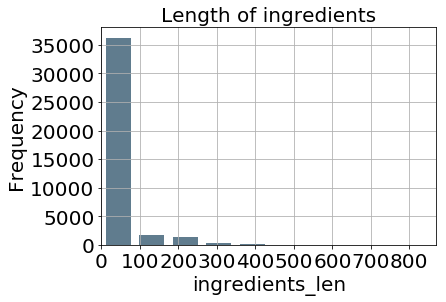

In [10]:
length = df.ingredients_len
length.plot.hist(grid=True, bins=10, rwidth=0.75,
                 color='#607c8e')
plt.title('Length of ingredients', fontsize=20)
plt.xlabel('ingredients_len', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlim(xmax=870, xmin=0)
plt.grid(axis='y', alpha=1)

Freqency table shows most of recipes are have ingredients_len less than 50, so I only kept recipes with 5 < ingredients_len < 50.

In [11]:
df_short = df[(df.ingredients_len < 50) & (df.ingredients_len > 5)]

In [12]:
df_short.describe()

,ingredients_len
count,32431.000000
mean,11.497764
std,4.241229
min,6.000000
25%,8.000000
50%,11.000000
75%,14.000000
max,49.000000


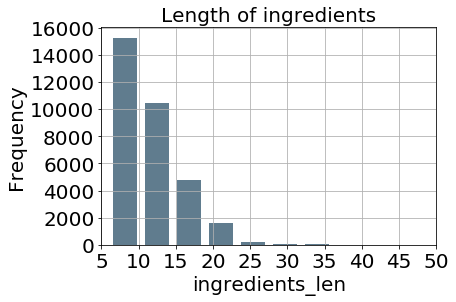

In [13]:
length = df_short.ingredients_len
length.plot.hist(grid=True, bins=10, rwidth=0.75,
                 color='#607c8e')
plt.title('Length of ingredients', fontsize=20)
plt.xlabel('ingredients_len', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlim(xmax=50, xmin=5)
plt.grid(axis='y', alpha=1)

### 4.3 Preprocess ingredients and Vectorize Data by TF-IDF
Most ingredients in the recipes are not single word, which increase the number of unique ingredients.
TF-IDF was used to decrease the weight of common ingredients such as oil, salt...

In [14]:
def dummy_clean(wordlist):
    return wordlist

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer = dummy_clean) 
word_count = count_vect.fit_transform(df_short['ingredients'])
print(word_count.shape)
print(count_vect.get_feature_names())

(32431, 6378)
[' ', '&', "'", '(    oz.) tomato sauce', '(   oz.) tomato paste', '(10 oz.) frozen chopped spinach', '(10 oz.) frozen chopped spinach, thawed and squeezed dry', '(14 oz.) sweetened condensed milk', '(14.5 oz.) diced tomatoes', '(15 oz.) refried beans', ',', '-', '1% low-fat buttermilk', '1% low-fat cottage cheese', '1% low-fat milk', '2 1/2 to 3 lb. chicken, cut into serving pieces', '2% low fat cheddar chees', '2% low-fat cottage cheese', '2% lowfat greek yogurt', '2% milk shredded mozzarella cheese', '2% reduced-fat milk', '25% less sodium chicken broth', '33% less sodium cooked deli ham', '33% less sodium cooked ham', '33% less sodium ham', '33% less sodium smoked fully cooked ham', '40% less sodium taco seasoning', '40% less sodium taco seasoning mix', '7 Up', '95% lean ground beef', 'A Taste of Thai Rice Noodles', 'Accent Seasoning', 'Adobo All Purpose Seasoning', 'Alaskan king crab legs', 'Alfredo sauce', 'Amarena cherries', 'Amaretti Cookies', 'American cheese', '

There are 6378 unique ingredients in 32431 recipes! It's tough to find common ingredients in the recipes, so let me preprocess the ingredients. They are usually combined with measures (e.g., spoon) and descriptive terms(e.g., frozen) that do not add anything to the recipe.

In [16]:
words_to_remove = ['litrbes', 'liter', 'millilitres', 'mL', 'grams', 'g', 'kg',
                   'teaspoon', 'tsp', 'tablespoon', 'tbsp', 'fluid', 'ounce',
                   'oz', 'fl.oz', 'cup', 'pint', 'pt', 'quart', 'qt', 'gallon',
                   'gal', 'smidgen', 'drop', 'pinch', 'dash', 'scruple', 'dessertspoon',
                   'teacup', 'cup', 'c', 'pottle', 'gill', 'dram', 'wineglass',
                   'coffeespoon', 'pound', 'lb', 'tbsp', 'plus', 'firmly', 'packed', 'finely',
                   'lightly', 'level', 'even', 'rounded', 'heaping', 'heaped', 'sifted',
                   'bushel', 'peck', 'stick', 'chopped', 'sliced', 'halves', 'shredded',
                   'slivered', 'sliced', 'whole', 'paste', 'whole', ' fresh', 'peeled', 'diced',
                   'mashed', 'dried', 'frozen', 'fresh', 'peeled', 'candied', 'no',
                   'pulp', 'crystallized', 'canned', 'crushed', 'minced', 'julienned',
                   'clove', 'head', 'small', 'large', 'medium', 'boneless', 'skinless', 
                   'skin', 'bone-in', 'bone', 'waxy', 'wax']

In [17]:
def clean_ingredient(wordlist):
    wl = nltk.WordNetLemmatizer()
    text=' '.join(wordlist).lower()
    text = text.replace('®', '')
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    nouns = [wl.lemmatize(word) for word in nouns if ((len(word)>2) & (word not in words_to_remove))]
    return nouns

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_ingredient)
df_tfidf = tfidf_vect.fit_transform(df['ingredients'])
word_tf_df = pd.DataFrame(df_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
word_tf_df.head()

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,yum,yuzu,za'atar,zatarains,zest,zesty,zinfandel,ziti,zucchini,épices
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(df_tfidf.shape)

(39774, 2141)


Now we refine the number of unique ingredient to 2141.

### 4.4 Clustering: K-means

In [21]:
from sklearn.cluster import KMeans

### 4.4.1 Find the best clustering number

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(word_tf_df)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbow showed at ~7.

### 4.4.2 Fit with 7 clusters

In [22]:
km = KMeans(n_clusters=7)
km = km.fit(word_tf_df)

In [23]:
clusters = km.predict(word_tf_df)
word_tf_df['Cluster'] = clusters

In [25]:
word_tf_df.head()

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,yuzu,za'atar,zatarains,zest,zesty,zinfandel,ziti,zucchini,épices,Cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


### 4.5 Use PCA to visualize the clustering

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca_2d = PCA(n_components=2)

In [28]:
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(word_tf_df.drop(["Cluster"], axis=1)))

In [29]:
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

In [30]:
word_tf_df2 = pd.concat([word_tf_df,PCs_2d], axis=1, join='inner')

In [31]:
word_tf_df2.head()

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,zatarains,zest,zesty,zinfandel,ziti,zucchini,épices,Cluster,PC1_2d,PC2_2d
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.017917,-0.012539
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.075815,0.067900
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.047882,-0.050750
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.075815,0.067900
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,-0.127778,-0.064884


In [34]:
plot_df = word_tf_df2.sample(5000, random_state = 42)

In [35]:
plot_df.head()

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,zatarains,zest,zesty,zinfandel,ziti,zucchini,épices,Cluster,PC1_2d,PC2_2d
21513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.097637,0.044073
1796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,-0.039939,-0.282920
21861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,-0.106701,-0.035092
26571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.041619,-0.046508
28720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.003830,0.027750


In [95]:
cluster = []
for i in range(7):
    cluster.append(plot_df[plot_df['Cluster'] == i]) 

In [59]:
#This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)

In [60]:
data = []
for i in range(7):     
    trace = go.Scatter(
                        x = cluster[i]['PC1_2d'],
                        y = cluster[i]['PC2_2d'],
                        mode = "markers",
                        name = "Cluster " + str(i),
                        text = None)
    data.append(trace)


title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False))

fig = dict(data = data, layout = layout)

iplot(fig)

In [40]:
pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(word_tf_df.drop(["Cluster"], axis=1)))
PCs_3d.columns = ["PC1_3d", "PC2_3d","PC3_3d"]
word_tf_df3 = pd.concat([word_tf_df,PCs_3d], axis=1, join='inner')
word_tf_df3.head()

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,zest,zesty,zinfandel,ziti,zucchini,épices,Cluster,PC1_3d,PC2_3d,PC3_3d
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.017955,-0.012542,-0.156365
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.075813,0.067940,-0.142076
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,0.047834,-0.050695,-0.074448
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.075813,0.067940,-0.142076
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,-0.127793,-0.064852,0.055268


In [56]:
plot_df2 = word_tf_df3.sample(5000)
plot_df2

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,zest,zesty,zinfandel,ziti,zucchini,épices,Cluster,PC1_3d,PC2_3d,PC3_3d
19689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.067890,-0.014018,-0.056926
27600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.282601,-0.015779,0.171983
38059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,-0.157491,-0.120602,-0.025525
13261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,-0.179076,-0.096222,0.056071
15694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,-0.210745,0.386311,0.233046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.259793,-0.038482,0.004857
28531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.075813,0.067940,-0.142076
26590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,-0.198223,0.007447,-0.075265
16212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,-0.066849,-0.141271,-0.062646


In [42]:
cluster2 = []
for i in range(7):
    cluster2.append(plot_df2[plot_df2['Cluster'] == i]) 
data2 = []
for i in range(7):     
    trace = go.Scatter3d(
                        x = cluster2[i]['PC1_3d'],
                        y = cluster2[i]['PC2_3d'],
                        z = cluster2[i]['PC3_3d'],
                        mode = "markers",
                        name = "Cluster " + str(i),
                        text = None)
    data2.append(trace)


title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False),
             )

fig = dict(data = data2, layout = layout)

iplot(fig)

In [96]:
keyword = []
for i in range(7):
    cluster[i].loc['sum'] = cluster[i].sum()
    cluster[i].drop(['Cluster', 'PC1_2d', 'PC2_2d'], axis = 1 ,inplace = True)
    cluster[i].sort_values('sum', axis=1, ascending=False, inplace=True, kind='quicksort')
    keyword.append(cluster[i].columns.tolist()[:200]) 

C:\Users\li_au\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
for i in range(7):
    print('Cluster #' + str(i))
    print(keyword[i])

Cluster #0
['vanilla', 'egg', 'sugar', 'milk', 'extract', 'butter', 'cream', 'yolk', 'flour', 'chocolate', 'salt', 'confectioner', 'cinnamon', 'almond', 'powder', 'water', 'corn', 'ground', 'orange', 'white', 'pecan', 'lemon', 'juice', 'coconut', 'cocoa', 'starch', 'syrup', 'peel', 'soda', 'brown', 'coffee', 'zest', 'semisweet', 'ice', 'pie', 'peach', 'pure', 'half', 'bean', 'spray', 'oil', 'crust', 'tartar', 'strawberry', 'buttermilk', 'stick', 'rum', 'morsel', 'honey', 'sweet', 'cheese', 'apple', 'whiskey', 'kosher', 'banana', 'lime', 'cake', 'yeast', 'dark', 'cherry', 'ricotta', 'chip', 'blueberry', 'pistachio', 'bourbon', 'sea', 'bittersweet', 'mix', 'cracker', 'granule', 'graham', 'food', 'whipping', 'potato', 'rice', 'walnut', 'wine', 'spice', 'espresso', 'ginger', 'baking', 'shell', 'bread', 'cooking', 'pastry', 'flake', 'vinegar', 'gelatin', 'wafer', 'raisin', 'currant', 'liqueur', 'nectarine', 'maple', 'caramel', 'brandy', 'prune', 'piecrusts', 'fruit', 'jam', 'flower', 'cranb

### 4.6 Find unique ingredients for each cluster

In [98]:
unique = [] # unique values in top 20 ingredients
for i in range(7):
    results_list = keyword[:i] + keyword[i+1:]
    union = set().union(*results_list)
    target = set(keyword[i])
    unique.append(target.difference(union))

In [99]:
for i in range(7):
    print('Cluster #' + str(i))
    print(unique[i])

Cluster #0
{'cooky', 'whipping', 'blossom', 'bosc', 'rhubarb', 'cottage', 'brioche', 'graham', 'fig', 'armagnac', 'biscotti', 'nectarine', 'ladyfinger', 'frangelico', 'flavor', 'anglaise', 'kumquat', 'granule', 'berry', 'extract', 'semisweet', 'morton', 'custard', 'cassava', 'blueberry', 'sauterne', 'dulce', 'safflower', 'bittersweet', 'biscuit', 'sambuca', 'pearl', 'whiskey', 'pack', 'devil', 'tart', 'yam', 'flower', 'whip', 'puff', 'piecrusts', 'scone', 'glace', 'sprinkle', 'bourbon', 'caramel', 'wafer', 'creme', 'tangerine', 'broccolini', 'braeburn', 'splenda', 'pie', 'liqueur', 'morsel', 'pudding', 'decorating', 'banana', 'toffee', 'coloring', 'cantaloupe', 'muscovado', 'nilla', 'apricot', 'bit', 'mission', 'turbinado', 'pink', 'dish', 'superfine', 'lavender', 'mincemeat', 'jam', 'essence', 'bailey', 'demerara', 'cracker', 'pure', 'grappa'}
Cluster #1
{'leek', 'masa', 'cube', 'salami', 'mayonnaise', 'crème', 'fraîche', 'dough', 'saltine', 'watercress'}
Cluster #2
{'shiso', 'creamy'

We matched each cluster with cuisine category.
* Topic #0 = Desserts
* Topic #1 = Pizza
* Topic #2 = Eest and Southeast Asian
* Topic #3 = Mexican
* Topic #4 = Italian
* Topic #5 = French
* Topic #6 = Indian

These keywords provide the hints to label the cuisines.

### 4.7 Topic Modeling with LDA

In [100]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [104]:
word_tf_df4 = word_tf_df.drop(['Cluster'], axis = 1)
word_tf_df4.head()

,abalone,abura,acai,accent,achiote,acid,acinus,ackee,acorn,adobo,...,yum,yuzu,za'atar,zatarains,zest,zesty,zinfandel,ziti,zucchini,épices
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
number_topics = 7
number_words = 100
lda = LDA(n_components=number_topics, n_jobs=-1,random_state = 42)
lda.fit(word_tf_df4)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=7, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [114]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

In [115]:
LDAvis_prepared = sklearn_lda.prepare(lda, df_tfidf, tfidf_vect)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

C:\Users\li_au\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


